# Параллельные вычисления (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

## Задачи для совместного разбора

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя пул процессов.

In [24]:
import multiprocessing
import pandas as pd

2. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя процессы и очереди.

## Лабораторная работа 5

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

<p class="task" id="1"></p>

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок). 

При создании файлов выводите на экран сообщения следующего вида:
`file: <название файла> #rows: <кол-во строк в этом файле>`

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [4]:
old_file = 'tag_nsteps.csv'
num_parts = 8
for i, chunk in enumerate(pd.read_csv(old_file, chunksize=int(71000000/num_parts))):
    new_file = f'tag_nsteps_{i}.csv'
    chunk.to_csv(new_file, index=False)
    print('Создание файла:', new_file, 'в котором', len(chunk),'строк')

Создание файла: tag_nsteps_0.csv в котором 8875000 строк
Создание файла: tag_nsteps_1.csv в котором 8875000 строк
Создание файла: tag_nsteps_2.csv в котором 8875000 строк
Создание файла: tag_nsteps_3.csv в котором 8875000 строк
Создание файла: tag_nsteps_4.csv в котором 8875000 строк
Создание файла: tag_nsteps_5.csv в котором 8875000 строк
Создание файла: tag_nsteps_6.csv в котором 8875000 строк
Создание файла: tag_nsteps_7.csv в котором 8570585 строк


<p class="task" id="2"></p>

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [5]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    tag_stats = df.groupby('tags').agg({'n_steps': ['sum', 'count']}) # группируем данные по тэгам и вычисляем сумму и количество строк для каждого тэга
    
    result = {}
    for tag, (sum_, count) in tag_stats.iterrows():
        result[tag] = {'sum': sum_, 'count': count}
    
    return result

агрегирования - это функция, которая принимает несколько отдельных значений и возвращает сводные данные.

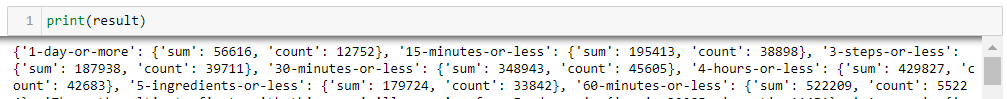

In [6]:
files = ['tag_nsteps_{}.csv'.format(i) for i in range(8)]
results = []
for file in files:
    result = get_tag_sum_count_from_file(file)
    results.append(result)
    
for i, result in enumerate(results):
    value = result.get('30-minutes-or-less')
    print('tag_nsteps',i,value)

tag_nsteps 0 {'sum': 348943, 'count': 45605}
tag_nsteps 1 {'sum': 350194, 'count': 46053}
tag_nsteps 2 {'sum': 353624, 'count': 46295}
tag_nsteps 3 {'sum': 347697, 'count': 45621}
tag_nsteps 4 {'sum': 346528, 'count': 45650}
tag_nsteps 5 {'sum': 350333, 'count': 46014}
tag_nsteps 6 {'sum': 346536, 'count': 45814}
tag_nsteps 7 {'sum': 339350, 'count': 44730}


<p class="task" id="3"></p>

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [7]:
def agg_results(tag_sum_count_list: list) -> dict:
    agg_dict = {}
    for tag_stats in tag_sum_count_list:
        for tag, stats in tag_stats.items():
            if tag not in agg_dict:
                agg_dict[tag] = {'sum': 0, 'count': 0}
            agg_dict[tag]['sum'] += stats['sum']
            agg_dict[tag]['count'] += stats['count']
    return agg_dict

tag_sum_count_list = []
for i in range(8):
    filename = f"tag_nsteps_{i}.csv"
    tag_sum_count = get_tag_sum_count_from_file(filename)
    tag_sum_count_list.append(tag_sum_count)

agg_dict = agg_results(tag_sum_count_list)
print(agg_dict['30-minutes-or-less'])

{'sum': 2783205, 'count': 365782}


<p class="task" id="4"></p>

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре. Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла, можно пренебречь.

In [8]:
#def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    #tag_mean = agg_dict['30-minutes-or-less']['sum'] / agg_dict['30-minutes-or-less']['count']
    #return tag_mean

In [57]:
#%%time
#get_tag_mean_n_steps(tag_sum_count)

Wall time: 0 ns


7.608917333275011

In [9]:
def get_mean_tag_nsteps(tag_sum_count_dict: dict) -> dict:
    result = {}
    for tag, stats in tag_sum_count_dict.items():
        result[tag] = stats['sum'] / stats['count']
    return result

In [10]:
%%time
tag_sum_count_list = []
for i in range(8):
    filename = f"tag_nsteps_{i}.csv"
    tag_sum_count = get_tag_sum_count_from_file(filename)
    tag_sum_count_list.append(tag_sum_count)

# агрегируем результаты
agg_dict = agg_results(tag_sum_count_list)

mean_dict = get_mean_tag_nsteps(agg_dict)
mean_dict['30-minutes-or-less']

Wall time: 37.6 s


7.608917333275011

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [ ]:
files = ['tag_nsteps_{}.csv'.format(i) for i in range(8)]

In [20]:
%%file new.py
import pandas as pd
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    x = df.groupby('tags')['n_steps'].agg(['sum','count']).to_dict(orient = 'index')
    return x

Overwriting new.py


In [30]:
mean_dict['30-minutes-or-less']

7.608917333275011

In [21]:
from new import get_tag_sum_count_from_file

In [26]:
%%time
with multiprocessing.Pool(processes = 8) as pool:
    ans = pool.map(get_tag_sum_count_from_file, files) 
agg_dict = agg_results(ans)
mean_dict = get_mean_tag_nsteps(agg_dict) 

Wall time: 7.88 s


запуск функции get_tag_sum_count_from_file на каждом файле из списка `files` с помощью метода `map` пула процессов.

<p class="task" id="6"></p>

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

<p class="task" id="7"></p>

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$ (воспользуйтесь функцией `multiprocessing.cpu_count`). Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [31]:
multiprocessing.cpu_count()

16

In [32]:
old_file = 'tag_nsteps.csv'
num_parts = 6
for i, chunk in enumerate(pd.read_csv(old_file, chunksize=int(71000000/num_parts))):
    new_file = f'tag_nsteps_{i}.csv'
    chunk.to_csv(new_file, index=False)
    print('Создание файла:', new_file, 'в котором', len(chunk),'строк')

Создание файла: tag_nsteps_0.csv в котором 11833333 строк
Создание файла: tag_nsteps_1.csv в котором 11833333 строк
Создание файла: tag_nsteps_2.csv в котором 11833333 строк
Создание файла: tag_nsteps_3.csv в котором 11833333 строк
Создание файла: tag_nsteps_4.csv в котором 11833333 строк
Создание файла: tag_nsteps_5.csv в котором 11528920 строк


In [33]:
lst=[f'tag_nsteps_{i}.csv' for i in range(6)]

In [35]:
%%timeit
with multiprocessing.Pool(processes = 8) as pool:
    ans = pool.map(get_tag_sum_count_from_file, lst) 
agg_dict = agg_results(ans)
mean_dict = get_mean_tag_nsteps(agg_dict)  

9.54 s ± 187 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
with multiprocessing.Pool(processes = 16) as pool:
    ans = pool.map(get_tag_sum_count_from_file, lst) 
agg_dict = agg_results(ans)
mean_dict = get_mean_tag_nsteps(agg_dict)  

9.63 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
with multiprocessing.Pool(processes = 32) as pool:
    ans = pool.map(get_tag_sum_count_from_file, lst) 
agg_dict = agg_results(ans)
mean_dict = get_mean_tag_nsteps(agg_dict)  

9.89 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


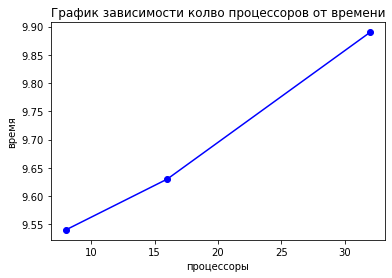

In [38]:
import matplotlib.pyplot as plt

a = [8, 16, 32]
b = [9.54, 9.63, 9.89]

plt.plot(a, b, 'bo-')  # 'bo-' синие круги соединенные линиями
plt.xlabel('процессоры')
plt.ylabel('время')
plt.title('График зависимости колво процессоров от времени')
plt.show()


Я думаю, что так произошло из-за качества железа, + я все время оставляю ноут в спящем режиме, что и сказалось на производительность